In [1]:
import numpy as np
import scanpy as sc
import scipy
from scipy.sparse import csr_matrix
import scanpy.external as sce
import pandas as pd
import matplotlib.pyplot as plt
from composition_stats import clr
import anndata as ad
import scirpy as ir
import muon as mu

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDepr

In [7]:
# load in everything, perform batch correction with harmony and the normal qc from scirpy

file_list = [
     ir.io.read_10x_vdj("lib_1/outs/per_sample_outs/lib_1/vdj_t/filtered_contig_annotations.csv"), 
     ir.io.read_10x_vdj("lib_2/outs/per_sample_outs/lib_2/vdj_t/filtered_contig_annotations.csv"), 
     ir.io.read_10x_vdj("lib_3/outs/per_sample_outs/lib_3/vdj_t/filtered_contig_annotations.csv")
]
# 14206, 15031, 14752

#labels = 14206*["lib1"] +  15031* ["lib2"]+ 14752*["lib3"]
new_l = []
for index in range(len(file_list)):
    adata = file_list[index]
    adata.obs["batch"] = "lib_" + str(index)
    new_l.append(adata)
    
tcr_concat = ad.concat(new_l, merge="same")
# add batch labels
tcr_concat.obs_names_make_unique()
# now TCR qc
ir.pp.index_chains(tcr_concat) # only needs airr
ir.tl.chain_qc(tcr_concat) # only needs airr

print(tcr_concat.obs.receptor_subtype)
raise Error
# further tcr qc
mu.pp.filter_obs(tcr_concat, "chain_pairing", lambda x: x != "multichain")
mu.pp.filter_obs(tcr_concat, "chain_pairing", lambda x: ~np.isin(x, ["orphan VDJ", "orphan VJ"]))
# it would appear that batch correction is ill-posed here.
# basic dim reduction for each modality
# sc.pp.pca(tcr_concat)
# # batch correction
# sce.pp.harmony_integrate(tcr_concat, 'batch') 
# then save it in same manner as other modalities
tcr_concat.write_h5ad('h5ads/correct_tcr.h5ad')

  0%|          | 0/3 [00:00<?, ?it/s]

['TRA+TRB']


  0%|          | 0/4 [00:00<?, ?it/s]

['TRA+TRB']


  0%|          | 0/3 [00:00<?, ?it/s]

['TRA+TRB']


ValueError: No objects to concatenate

In [6]:
print(tcr_concat.obs.receptor_subtype.unique())

['TRA+TRB']


In [2]:
# load in files 
file_list = [
    sc.read_h5ad("h5ads/correct_rna.h5ad"),
    sc.read_h5ad("h5ads/correct_tcr.h5ad"),
    sc.read_h5ad("h5ads/correct_protein.h5ad")
]
for adata in file_list:
    try:
        adata.uns['log1p']["base"] = None 
    except:
        pass
# fill out the mudata object
mdata = mu.MuData({"gex": file_list[0],  
                   "airr": file_list[1],
                   "prot": file_list[2]})

mdata["gex"], mdata["airr"], mdata["prot"]

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/anndata/_core/aligned_mapping.py:54: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(


(AnnData object with n_obs × n_vars = 47024 × 28608
     obs: 'TotalSeq-C0251 anti-human Hashtag 1 Antibody', 'TotalSeq-C0252 anti-human Hashtag 2 Antibody', 'TotalSeq-C0253 anti-human Hashtag 3 Antibody', 'TotalSeq-C0254 anti-human Hashtag 4 Antibody', 'TotalSeq-C0255 anti-human Hashtag 5 Antibody', 'TotalSeq-C0256 anti-human Hashtag 6 Antibody', 'TotalSeq-C0257 anti-human Hashtag 7 Antibody', 'TotalSeq-C0258 anti-human Hashtag 8 Antibody', 'TotalSeq-C0259 anti-human Hashtag 9 Antibody', 'TotalSeq-C0260 anti-human Hashtag 10 Antibody', 'TotalSeq-C0262 anti-human Hashtag 12 Antibody', 'TotalSeq-C0263 anti-human Hashtag 13 Antibody', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'Thaw', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb'
     var: 'gene_ids', 'featu

In [4]:
mdata["airr"].obs.receptor_subtype

cell_id
AAACCTGAGACTAAGT-1      TRA+TRB
AAACCTGAGCAATCTC-1      TRA+TRB
AAACCTGAGCCCAGCT-1      TRA+TRB
AAACCTGAGCTCCTCT-1      TRA+TRB
AAACCTGAGGACGAAA-1      TRA+TRB
                         ...   
TTTGTCAGTGAAAGAG-1      TRA+TRB
TTTGTCAGTGAAGGCT-1      TRA+TRB
TTTGTCATCACGATGT-1      TRA+TRB
TTTGTCATCCACTGGG-1      TRA+TRB
TTTGTCATCTTGGGTA-1-1    TRA+TRB
Name: receptor_subtype, Length: 40077, dtype: category
Categories (1, object): ['TRA+TRB']

In [9]:
airr_cell_ids = set(mdata["airr"].obs.index)
gex_cell_ids = set(mdata["gex"].obs.index)
prot_cell_ids = set(mdata["prot"].obs.index)

In [11]:
airr_cell_ids

{'AGAATAGTCGTTACAG-1',
 'CATCCACAGTGACTCT-1',
 'GGTGAAGTCATGGTCA-1',
 'GGAATAAAGACTCGGA-1',
 'AGCGTATAGGTCGGAT-1',
 'GACGTGCTCAAACCAC-1',
 'TAAGTGCCACAGTCGC-1',
 'AACTCTTAGGTTACCT-1',
 'CTCATTAAGTGTTTGC-1',
 'TCTGGAACATGCAATC-1',
 'ATTGGACCACTGAAGG-1',
 'GCTTGAACAAGTTCTG-1',
 'TTTGTCATCGTTACAG-1',
 'CTTCTCTCATTCCTGC-1',
 'CTGCTGTCAATCTGCA-1',
 'CTACACCGTGTCTGAT-1',
 'TTCGGTCTCCAGAAGG-1',
 'TACAGTGGTATAGGGC-1',
 'GATGAAAGTAAGCACG-1',
 'TAGACCACACAAGACG-1',
 'TATCTCATCCGTTGCT-1',
 'TTGTAGGTCGCAAGCC-1',
 'CTTTGCGTCTAACGGT-1',
 'TCACGAACACTGTCGG-1',
 'GGCCGATCAAGCTGGA-1',
 'GTACTTTGTGTAATGA-1',
 'CTTGGCTGTGCAGGTA-1',
 'TGCTACCCATAGACTC-1-1',
 'TTGACTTGTACCAGTT-1',
 'TGAGCATTCGCTGATA-1',
 'GACTAACGTGGCAAAC-1',
 'ATTACTCGTTCATGGT-1',
 'CCCAATCGTCTAGTGT-1',
 'TATGCCCCAGGGTACA-1',
 'GTTCTCGAGACCCACC-1',
 'ACTGTCCGTCCGCTGA-1',
 'GTAACGTCATAAGACA-1',
 'TTGTAGGAGCTAGTCT-1',
 'CGAGCCAAGAGCCCAA-1',
 'ATCTGCCTCCACTCCA-1',
 'ATGGGAGGTATATCCG-1',
 'CAACCAACAGATCGGA-1',
 'AATCGGTTCGCTGATA-1',
 'CTACACC

In [13]:
gex_cell_ids

{'AGAATAGTCGTTACAG-1',
 'CATCCACAGTGACTCT-1',
 'GGTGAAGTCATGGTCA-1',
 'CGTAGCGAGTCAAGGC-1',
 'ATCTACTAGTGCGTGA-1',
 'GGAATAAAGACTCGGA-1',
 'AGCGTATAGGTCGGAT-1',
 'GACGTGCTCAAACCAC-1',
 'ATTGGACCACTGAAGG-1',
 'GCTTGAACAAGTTCTG-1',
 'GTATCTTAGAATCTCC-1',
 'TTTGTCATCGTTACAG-1',
 'CTGCTGTCAATCTGCA-1',
 'CTACACCGTGTCTGAT-1',
 'CTTCTCTCATTCCTGC-1',
 'TTCGGTCTCCAGAAGG-1',
 'TACAGTGGTATAGGGC-1',
 'TTCGAAGAGGCATGGT-1',
 'GATGAAAGTAAGCACG-1',
 'GATGCTAGTCAATACC-1',
 'TTGTAGGTCGCAAGCC-1',
 'AGGGTGAAGCAGATCG-1',
 'ACGCAGCGTTGTACAC-1',
 'TCACGAACACTGTCGG-1',
 'GGCCGATCAAGCTGGA-1',
 'GTCCTCACAAACGCGA-1',
 'CTTGGCTGTGCAGGTA-1',
 'TGCTACCCATAGACTC-1-1',
 'GCGCAGTCAAGGTGTG-1',
 'TTGACTTGTACCAGTT-1',
 'TGACAACTCGTAGATC-1-1',
 'TGAGCATTCGCTGATA-1',
 'ATTACTCGTTCATGGT-1',
 'CCCAATCGTCTAGTGT-1',
 'TACTCATAGCGTCTAT-1',
 'GTTCTCGAGACCCACC-1',
 'ACATCAGTCAACTCTT-1',
 'GTAACGTCATAAGACA-1',
 'AAATGCCGTCCAAGTT-1',
 'TTGTAGGAGCTAGTCT-1',
 'GACTAACCAATCACAC-1',
 'CGAGCCAAGAGCCCAA-1',
 'ATCTGCCTCCACTCCA-1',
 'ATGGG

In [ ]:
prot_cell_ids

In [8]:
len(airr_cell_ids), len(gex_cell_ids), len(prot_cell_ids)

(40077, 47024, 47024)

In [10]:
# check if there are cell barcodes that exist in airr and not in gex
#len(airr_cell_ids - gex_cell_ids), len(prot_cell_ids - gex_cell_ids), len(prot_cell_ids - airr_cell_ids), len(airr_cell_ids - prot_cell_ids)
# check if there are cell barcodes that exist in prot and not in gex
len(gex_cell_ids - airr_cell_ids)
# check if there are cell barcodes that exist in prot and not in airr

21596

  0%|          | 0/13524 [00:00<?, ?it/s]

<Axes: >

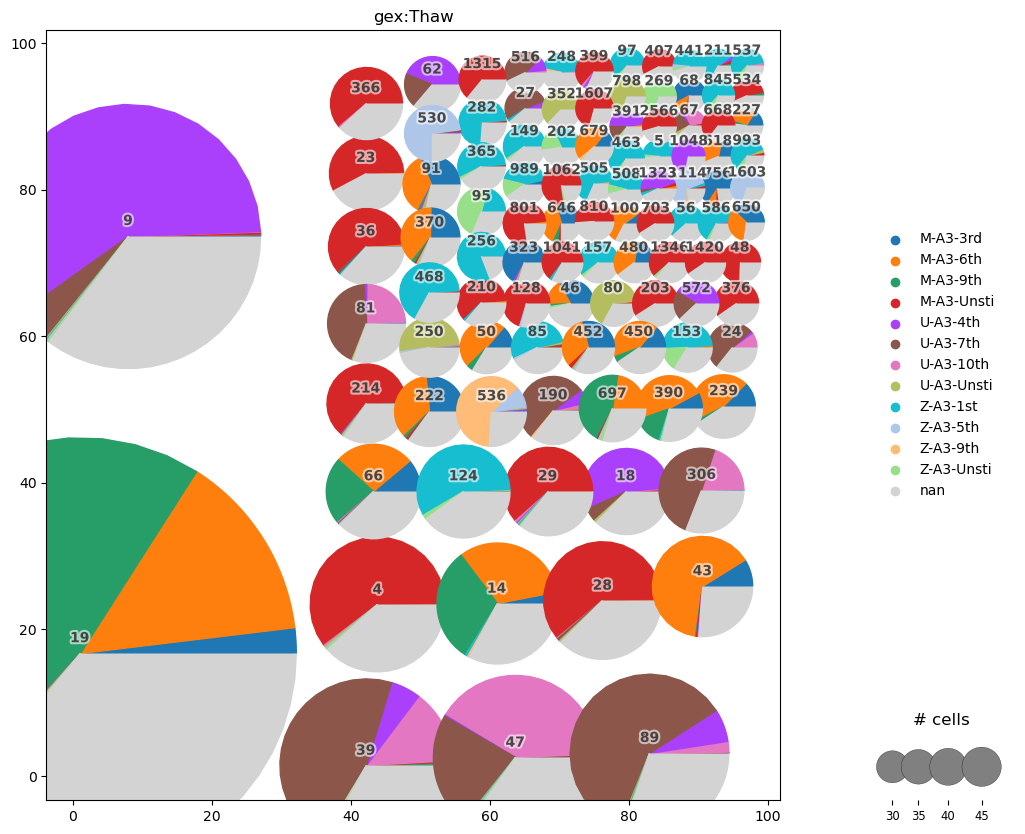

In [15]:
# define clonotypes
# using default parameters, `ir_dist` will compute nucleotide sequence identity
ir.pp.ir_dist(mdata)
ir.tl.define_clonotypes(mdata, receptor_arms="all", dual_ir="primary_only")
ir.tl.clonotype_network(mdata, min_cells=30) #50, 100 is good
# we don't have source, just use sample labels here
ir.pl.clonotype_network( # color='Thaw'
    mdata,color='gex:Thaw') #, base_size=20, label_fontsize=9, panel_size=(7, 7)
#)

<Axes: >

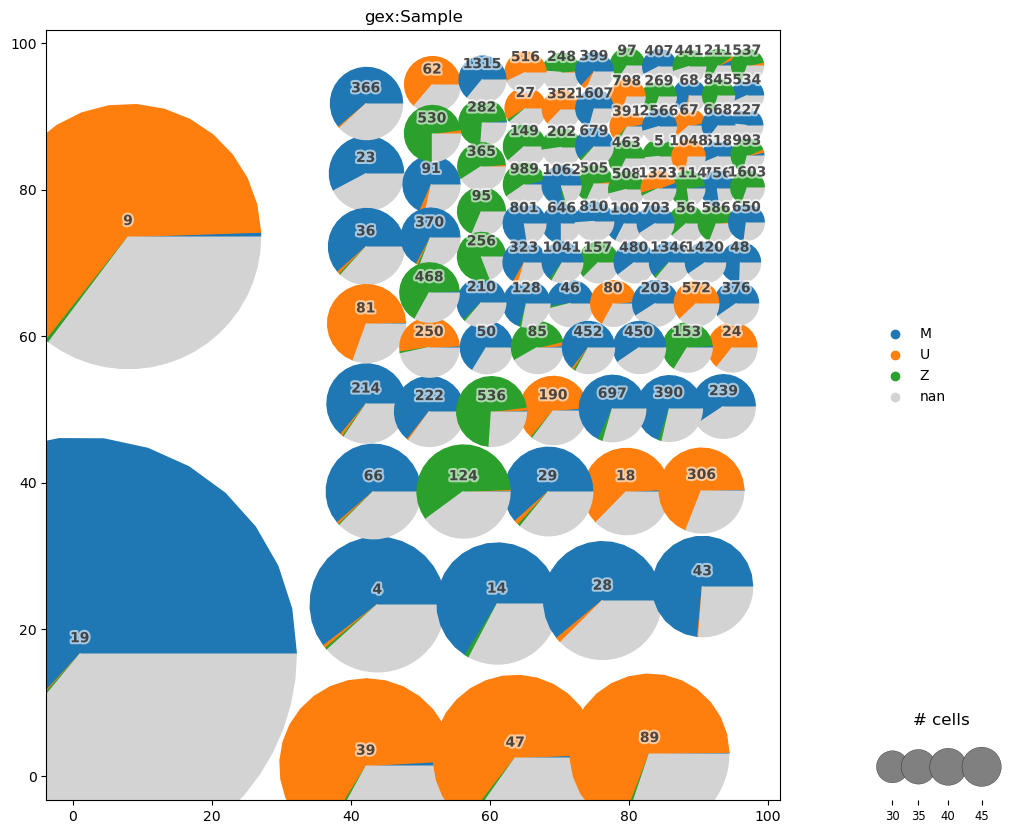

In [62]:
# we don't have source, just use sample labels here
ir.pl.clonotype_network( # color='Thaw'
    mdata,color='gex:Sample') #, base_size=20, label_fontsize=9, panel_size=(7, 7)
#)

<Axes: >

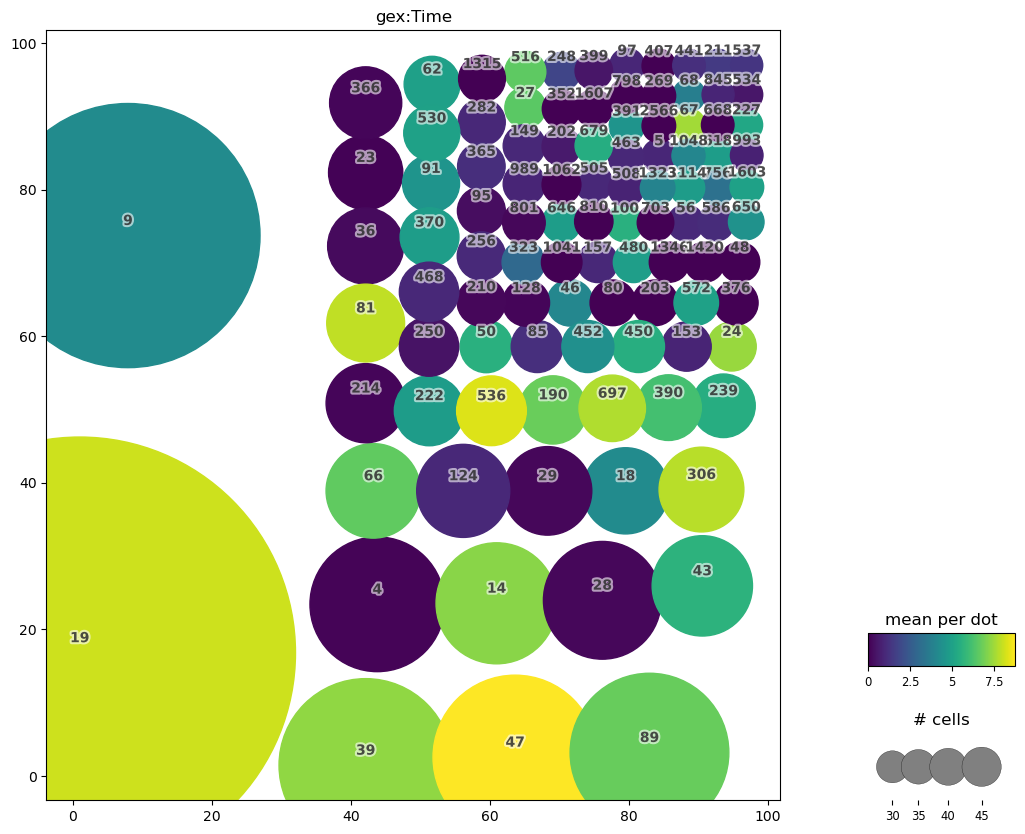

In [63]:
# we don't have source, just use sample labels here
ir.pl.clonotype_network( # color='Thaw'
    mdata,color='gex:Time') #, base_size=20, label_fontsize=9, panel_size=(7, 7)
#)

In [ ]:
# re-compute the clonotype network based on amino-acid sequence similarity and 
# define clonotype clusters.
ir.pp.ir_dist(
    mdata,
    metric="alignment",
    sequence="aa", # tried 15, 25, 10, was garbage
    cutoff=10,# was 15, I would try 10 next -- definitely faster with the smaller number
)
ir.tl.define_clonotype_clusters(
    mdata, sequence="aa", metric="alignment", receptor_arms="all", dual_ir= "primary_only" #"any"
)


  0%|          | 0/34980 [00:00<?, ?it/s]

  0%|          | 0/33670 [00:00<?, ?it/s]

<Axes: >

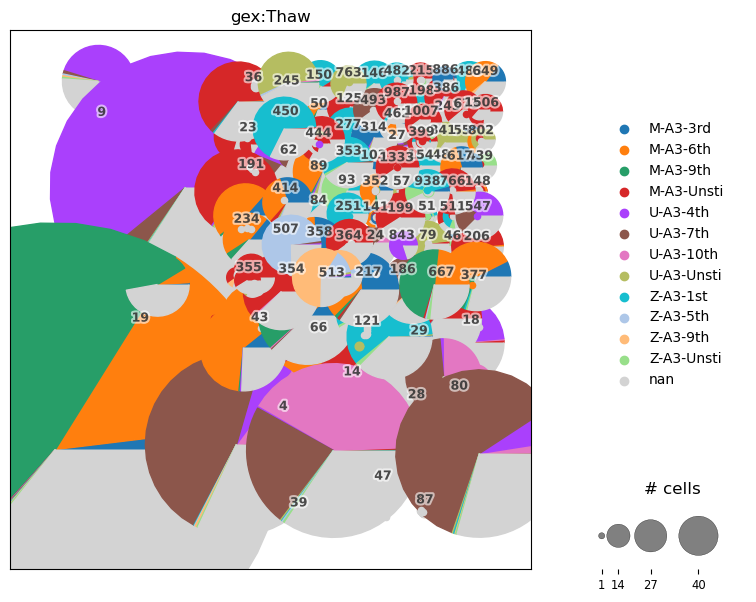

In [75]:
ir.tl.clonotype_network(mdata, min_cells=40, sequence="aa", metric="alignment")
ir.pl.clonotype_network(
    mdata, color="gex:Thaw", label_fontsize=9, panel_size=(7, 7), base_size=20
)
# again color by your labels, not theirs

In [ ]:
ir.tl.clonotype_network(mdata, min_cells=33, sequence="aa", metric="alignment")
ir.pl.clonotype_network(
    mdata, color="gex:Sample", label_fontsize=9, panel_size=(7, 7), base_size=20
)

In [ ]:
ir.tl.clonotype_network(mdata, min_cells=33, sequence="aa", metric="alignment")
ir.pl.clonotype_network(
    mdata, color="gex:Time", label_fontsize=9, panel_size=(7, 7), base_size=20
)

In [7]:
mdata["airr"].obsm['airr']

<Array [[{c_call: 'TRAC', ...}, ...], ...] type='43989 * var * {c_call: ?st...'>

In [4]:
mdata["airr"].obsm['chain_indices']

<Array [{multichain: False, VJ: ..., ...}, ...] type='43989 * {multichain: ...'>

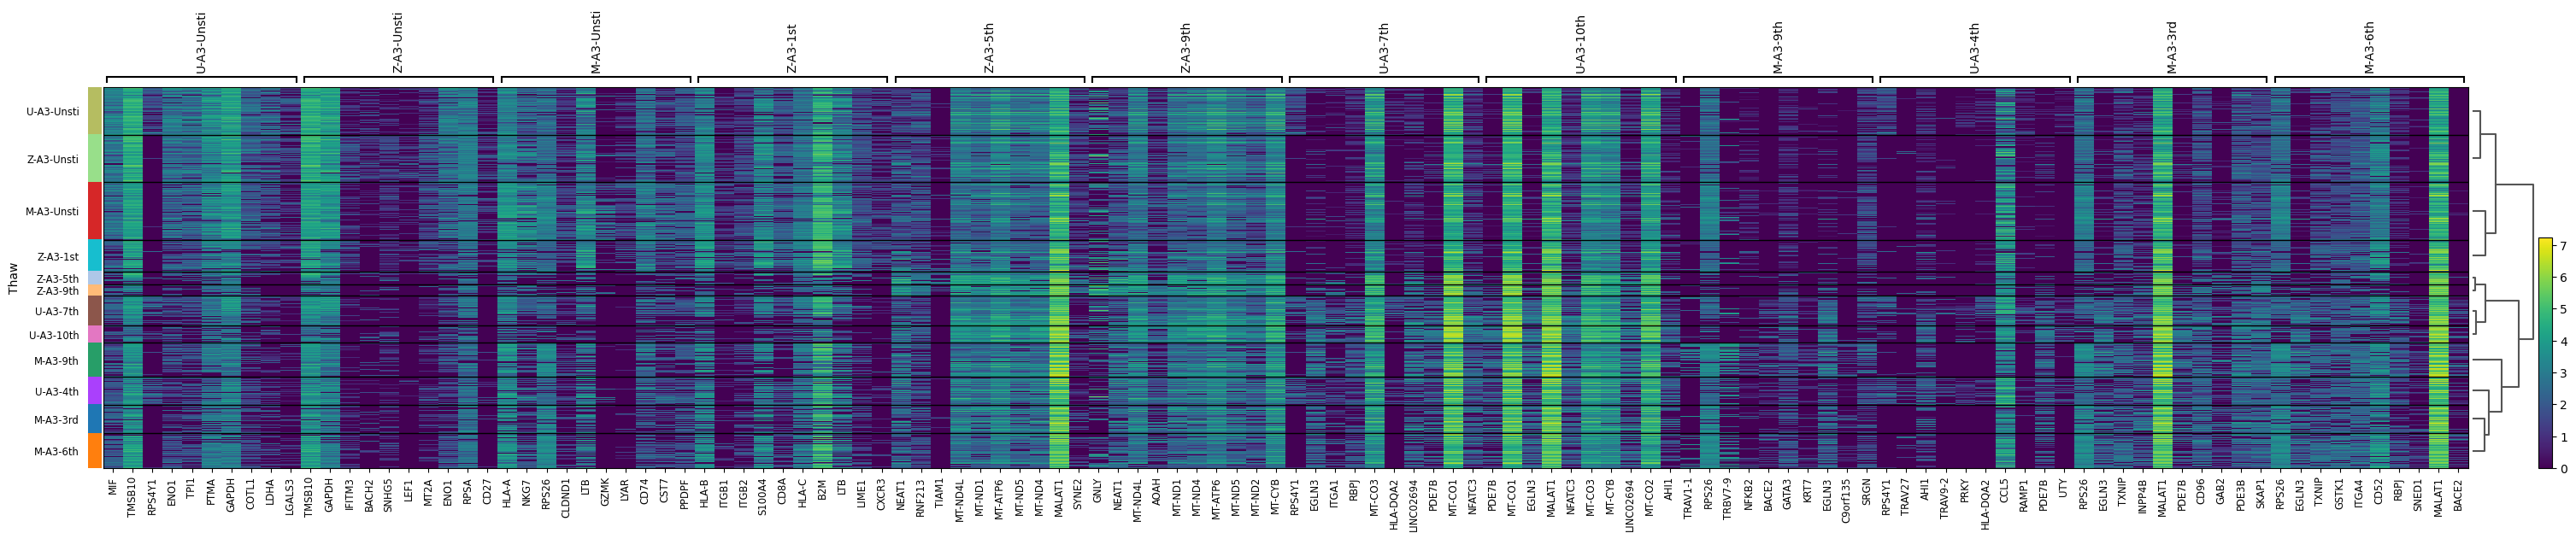

In [4]:
# task 1 
# this is a little more complicated due to the nature of the data itself (these are not even scalars!)

# wants sample by TCR airr heatmap as one graph, 
# with hierarchical clustering on the opposing axises and colored by differential expression
sc.tl.rank_genes_groups(mdata["gex"], groupby='Thaw', method='wilcoxon')#, key_added = "wilcoxon")
#sc.pl.rank_genes_groups(mdata["gex"], n_genes=10, groupby='cluster')
#sc.pl.rank_genes_groups_matrixplot(adata, n_genes=5, key="thaw", groupby="louvain_0.6") 
# you can use this to give you mean expression in groups
sc.pl.rank_genes_groups_heatmap(mdata["gex"], 
                                n_genes=10, groupby='Thaw', show_gene_labels=True,) # save="heatmap.png")

In [18]:
# create some mask on gex data to only have tcr receptor expression

mdata["gex"].var.gene_ids


AL627309.1    ENSG00000238009
AL627309.3    ENSG00000239945
AL627309.5    ENSG00000241860
AP006222.2    ENSG00000286448
LINC01409     ENSG00000237491
                   ...       
AC240274.1    ENSG00000271254
AC004556.3    ENSG00000276345
AC233755.2    ENSG00000277856
AC007325.4    ENSG00000278817
AC007325.2    ENSG00000277196
Name: gene_ids, Length: 28608, dtype: object

In [37]:
mdata["gex"].obs.Thaw 

AAACCTGAGACTAAGT-1        M-A3-3rd
AAACCTGAGAGGGATA-1        M-A3-6th
AAACCTGAGATGTAAC-1      Z-A3-Unsti
AAACCTGAGCAATCTC-1      M-A3-Unsti
AAACCTGAGCCCAGCT-1      U-A3-Unsti
                           ...    
TTTGTCATCACGATGT-1        M-A3-3rd
TTTGTCATCCGCGTTT-1        U-A3-7th
TTTGTCATCCTACAGA-1        M-A3-6th
TTTGTCATCGTCTGCT-1      U-A3-Unsti
TTTGTCATCTTGGGTA-1-1    M-A3-Unsti
Name: Thaw, Length: 47024, dtype: category
Categories (12, object): ['M-A3-3rd', 'M-A3-6th', 'M-A3-9th', 'M-A3-Unsti', ..., 'Z-A3-1st', 'Z-A3-5th', 'Z-A3-9th', 'Z-A3-Unsti']

In [41]:
len(mdata["gex"].obs[mdata["gex"].obs.Thaw == "Z-A3-1st"].index)

3895

In [30]:
mdata["prot"].var.gene_ids

Hu.CD101                                         ADT_C0944
Hu.CD103                                         ADT_C0145
Hu.CD105_43A3                                    ADT_C0068
Hu.CD107a                                        ADT_C0155
Hu.CD112                                         ADT_C0024
                                                   ...    
TotalSeq-C0258 anti-human Hashtag 8 Antibody             8
TotalSeq-C0259 anti-human Hashtag 9 Antibody             9
TotalSeq-C0260 anti-human Hashtag 10 Antibody           10
TotalSeq-C0262 anti-human Hashtag 12 Antibody           12
TotalSeq-C0263 anti-human Hashtag 13 Antibody           13
Name: gene_ids, Length: 149, dtype: object

In [28]:
"ADT_C0090" in list(mdata["prot"].var.gene_ids)
#just do the second paper's qc and redo all the protein + gex stuff
# MouseIgG1, MouseIgG2a, MouseIgG2b, RatIgG2b, RatIgG1, RatIgG2a, and HamsterIgG
# C0090, C0091, C0092, C0095
# match these to ADT tags based on the file Xiao gave you

True

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


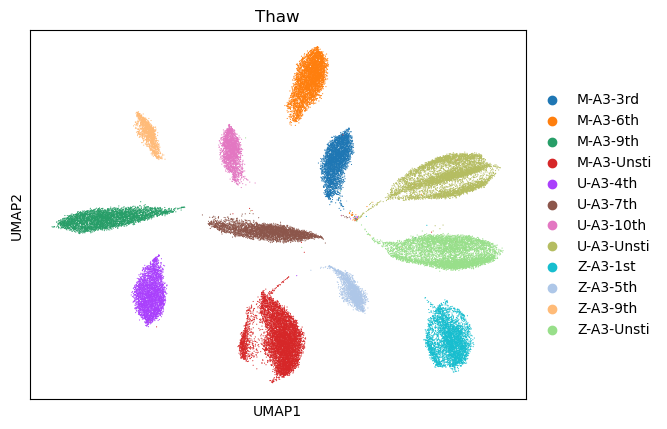

In [5]:
sc.tl.umap(mdata["prot"])
sc.pl.umap(mdata["prot"], color='Thaw',) # save="UMAP.png")

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


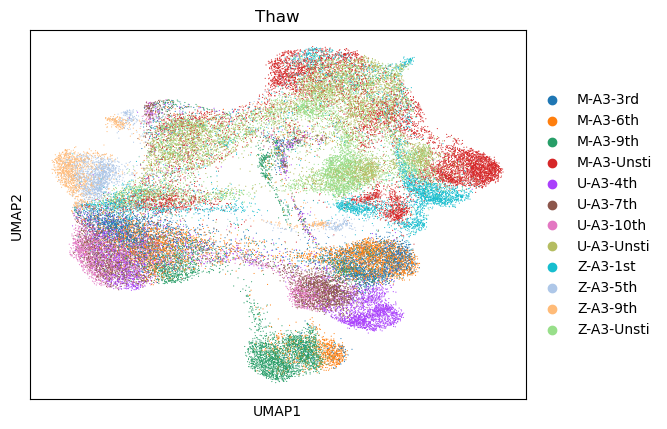

In [17]:
sc.tl.umap(mdata["gex"])
sc.pl.umap(mdata["gex"], color='Thaw',)

In [40]:
mdata["gex"]

AnnData object with n_obs × n_vars = 47024 × 28608
    obs: 'TotalSeq-C0251 anti-human Hashtag 1 Antibody', 'TotalSeq-C0252 anti-human Hashtag 2 Antibody', 'TotalSeq-C0253 anti-human Hashtag 3 Antibody', 'TotalSeq-C0254 anti-human Hashtag 4 Antibody', 'TotalSeq-C0255 anti-human Hashtag 5 Antibody', 'TotalSeq-C0256 anti-human Hashtag 6 Antibody', 'TotalSeq-C0257 anti-human Hashtag 7 Antibody', 'TotalSeq-C0258 anti-human Hashtag 8 Antibody', 'TotalSeq-C0259 anti-human Hashtag 9 Antibody', 'TotalSeq-C0260 anti-human Hashtag 10 Antibody', 'TotalSeq-C0262 anti-human Hashtag 12 Antibody', 'TotalSeq-C0263 anti-human Hashtag 13 Antibody', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'Thaw', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


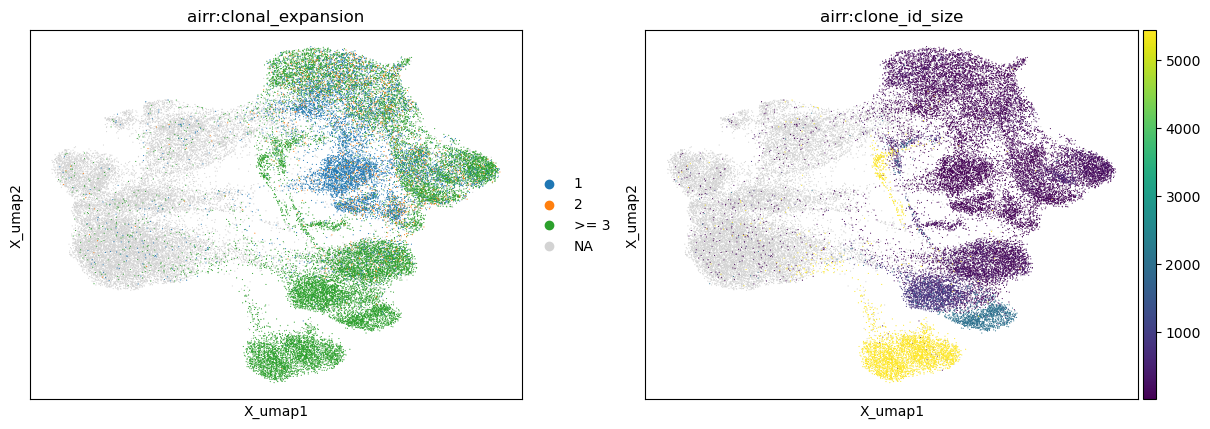

<Axes: >

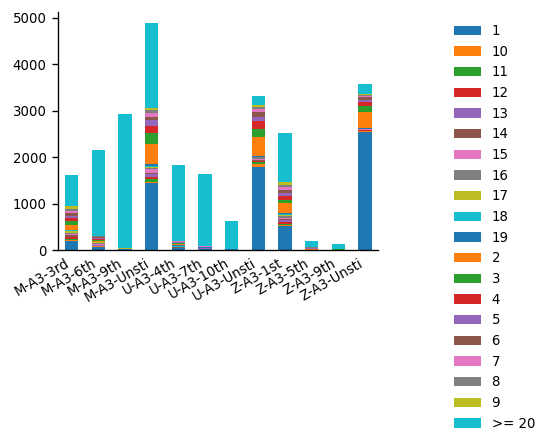

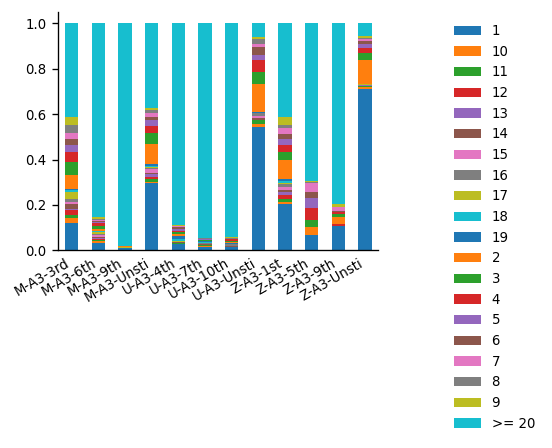

In [18]:
# clonal expansion -- do all this for each sample (do one for all samples, then do by donor)
ir.tl.clonal_expansion(mdata)
mu.pl.embedding(
    mdata, basis="gex:umap", color=["airr:clonal_expansion", "airr:clone_id_size"]
)
# need to have the rna data umap computed
# again change the groupby to use your sample labels
ir.pl.clonal_expansion( # groupby="gex:cluster"
    mdata, target_col="clone_id" , clip_at=20, normalize=False, groupby="gex:Thaw"
)
ir.pl.clonal_expansion(mdata, target_col="clone_id",clip_at=20, groupby="gex:Thaw")

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


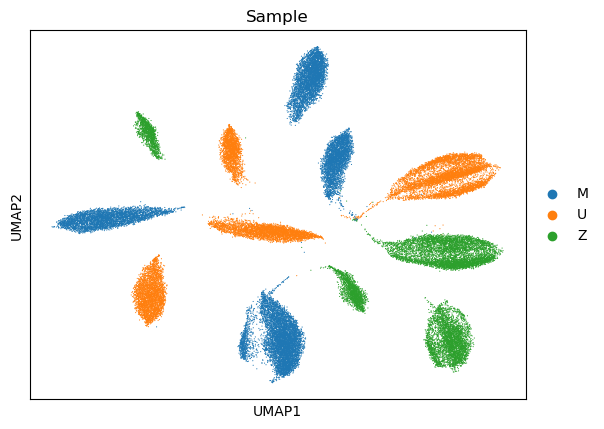

In [47]:
# task 2
# we must be missing a thaw label

# UMAP from protein data, where the clusters are colored by sample name
# create a new column called Sample that applies the predefined sample map
thaw_to_donor = {
    'Z-A3-Unsti' : "Z",
    'Z-A3-1st' : "Z", 
    'Z-A3-5th' : "Z",  
    'Z-A3-9th' : "Z",    
    "M-A3-Unsti" : "M",  
    "M-A3-3rd" : "M",
    "M-A3-6th": "M",
    "M-A3-9th" : "M",
    "U-A3-Unsti" : "U",
    "U-A3-4th" : "U",
    "U-A3-7th": "U",
    "U-A3-10th": "U"
}
# U-A3-Unsti is not getting picked up here

# [print(i)for i in mdata["prot"].obs['Thaw'].unique()]
# raise Error
mdata["prot"].obs["Sample"] = mdata["prot"].obs['Thaw'].map(thaw_to_donor)
mdata["gex"].obs["Sample"] = mdata["gex"].obs['Thaw'].map(thaw_to_donor)

sc.tl.umap(mdata["prot"])
sc.pl.umap(mdata["prot"], color='Sample',) # save="UMAP.png")

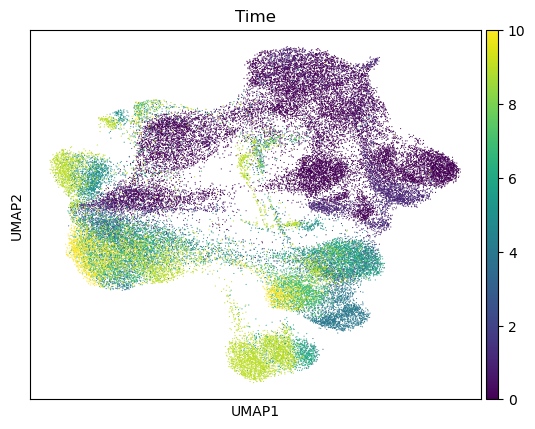

In [46]:
# task 3
# 3 UMAPs (one for each donor), non-TCR-repertoire RNA, color by different time points
# create a new column called Sample that applies the predefined sample map
thaw_to_time = {
    
    'Z-A3-Unsti' : 0,
    'Z-A3-1st' : 1, 
    'Z-A3-5th' : 5,  
    'Z-A3-9th' : 9,    
    "M-A3-Unsti" : 0,  
    "M-A3-3rd" : 3,
    "M-A3-6th": 6,
    "M-A3-9th" : 9,
    "U-A3-Unsti" : 0,
    "U-A3-4th" : 4,
    "U-A3-7th": 7,
    "U-A3-10th": 10
}
mdata["gex"].obs["Time"] = mdata["gex"].obs['Thaw'].map(thaw_to_time)
sc.tl.umap(mdata["gex"])
sc.pl.umap(mdata["gex"], color='Time' )#, save="UMAP.png")

In [50]:
mdata.update()
mdata["gex"]

AnnData object with n_obs × n_vars = 47024 × 28608
    obs: 'TotalSeq-C0251 anti-human Hashtag 1 Antibody', 'TotalSeq-C0252 anti-human Hashtag 2 Antibody', 'TotalSeq-C0253 anti-human Hashtag 3 Antibody', 'TotalSeq-C0254 anti-human Hashtag 4 Antibody', 'TotalSeq-C0255 anti-human Hashtag 5 Antibody', 'TotalSeq-C0256 anti-human Hashtag 6 Antibody', 'TotalSeq-C0257 anti-human Hashtag 7 Antibody', 'TotalSeq-C0258 anti-human Hashtag 8 Antibody', 'TotalSeq-C0259 anti-human Hashtag 9 Antibody', 'TotalSeq-C0260 anti-human Hashtag 10 Antibody', 'TotalSeq-C0262 anti-human Hashtag 12 Antibody', 'TotalSeq-C0263 anti-human Hashtag 13 Antibody', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'Thaw', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'Time', 'Sample'
    var: 'ge

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


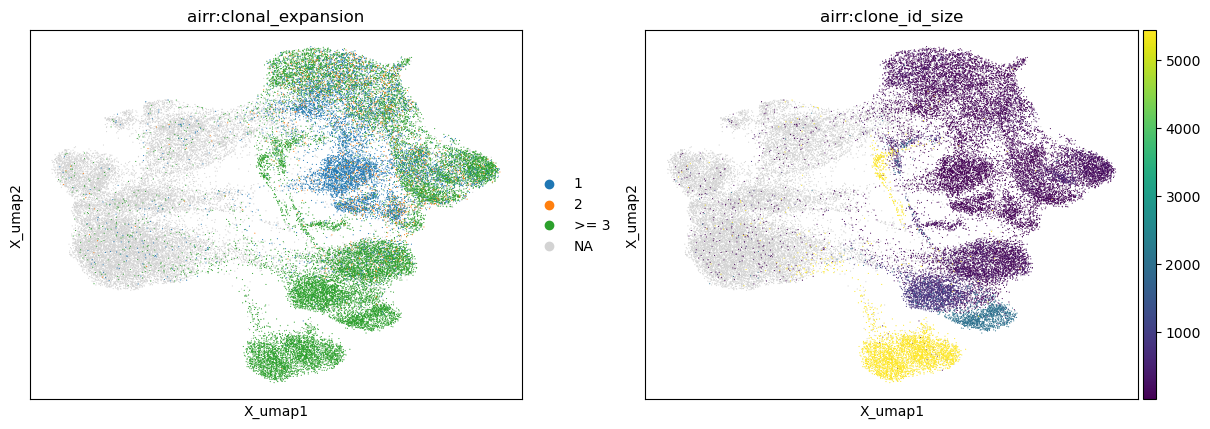

<Axes: >

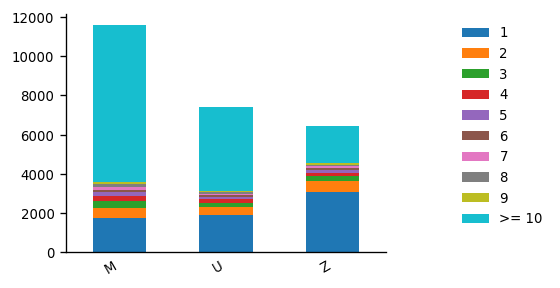

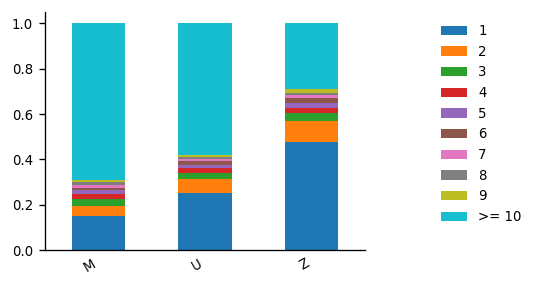

In [59]:
# clonal expansion -- do all this for each sample (do one for all samples, then do by donor)
ir.tl.clonal_expansion(mdata)
mu.pl.embedding(
    mdata, basis="gex:umap", color=["airr:clonal_expansion", "airr:clone_id_size"]
)
# need to have the rna data umap computed
# again change the groupby to use your sample labels
ir.pl.clonal_expansion( # groupby="gex:cluster"
    mdata, target_col="clone_id" , clip_at=10, normalize=False, groupby="gex:Sample"
)
ir.pl.clonal_expansion(mdata, target_col="clone_id", clip_at=10, groupby="gex:Sample")

/root/mambaforge/envs/Xiao/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


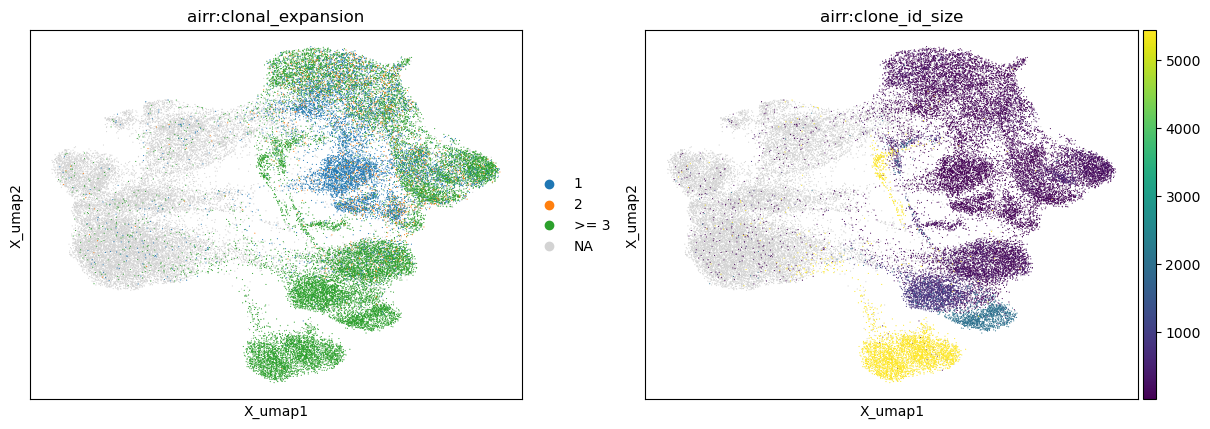

<Axes: >

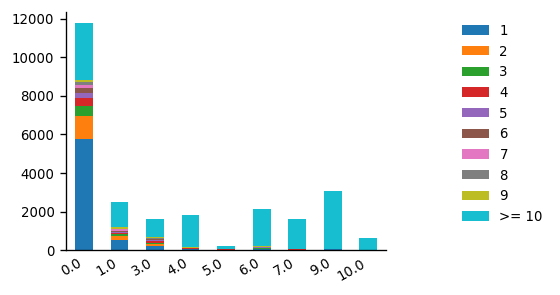

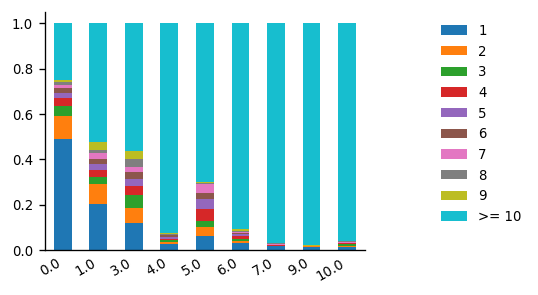

In [58]:
# clonal expansion -- do all this for each sample (do one for all samples, then do by donor)
ir.tl.clonal_expansion(mdata)
mu.pl.embedding(
    mdata, basis="gex:umap", color=["airr:clonal_expansion", "airr:clone_id_size"]
)
# need to have the rna data umap computed
# again change the groupby to use your sample labels
ir.pl.clonal_expansion( # groupby="gex:cluster"
    mdata, target_col="clone_id" , clip_at=10, normalize=False, groupby="gex:Time"
)
ir.pl.clonal_expansion(mdata, target_col="clone_id", clip_at=10, groupby="gex:Time")

In [12]:
# now let's examine the tcr data more
mdata["airr"].obs.receptor_type

cell_id
AAACCTGAGACTAAGT-1      TCR
AAACCTGAGAGGGATA-1      TCR
AAACCTGAGCAATCTC-1      TCR
AAACCTGAGCCCAGCT-1      TCR
AAACCTGAGCTCCTCT-1      TCR
                       ... 
TTTGTCAGTGAAAGAG-1      TCR
TTTGTCAGTGAAGGCT-1      TCR
TTTGTCATCACGATGT-1      TCR
TTTGTCATCCACTGGG-1      TCR
TTTGTCATCTTGGGTA-1-1    TCR
Name: receptor_type, Length: 43989, dtype: category
Categories (1, object): ['TCR']

In [13]:
mdata["airr"].obs.receptor_subtype

cell_id
AAACCTGAGACTAAGT-1      TRA+TRB
AAACCTGAGAGGGATA-1      TRA+TRB
AAACCTGAGCAATCTC-1      TRA+TRB
AAACCTGAGCCCAGCT-1      TRA+TRB
AAACCTGAGCTCCTCT-1      TRA+TRB
                         ...   
TTTGTCAGTGAAAGAG-1      TRA+TRB
TTTGTCAGTGAAGGCT-1      TRA+TRB
TTTGTCATCACGATGT-1      TRA+TRB
TTTGTCATCCACTGGG-1      TRA+TRB
TTTGTCATCTTGGGTA-1-1    TRA+TRB
Name: receptor_subtype, Length: 43989, dtype: category
Categories (1, object): ['TRA+TRB']

In [14]:
mdata["airr"].obs.chain_pairing

cell_id
AAACCTGAGACTAAGT-1         extra VJ
AAACCTGAGAGGGATA-1        orphan VJ
AAACCTGAGCAATCTC-1         extra VJ
AAACCTGAGCCCAGCT-1      single pair
AAACCTGAGCTCCTCT-1        extra VDJ
                           ...     
TTTGTCAGTGAAAGAG-1      single pair
TTTGTCAGTGAAGGCT-1      single pair
TTTGTCATCACGATGT-1         extra VJ
TTTGTCATCCACTGGG-1      single pair
TTTGTCATCTTGGGTA-1-1    single pair
Name: chain_pairing, Length: 43989, dtype: category
Categories (6, object): ['extra VDJ', 'extra VJ', 'orphan VDJ', 'orphan VJ', 'single pair', 'two full chains']